# **Time Series Analysis Project**

**Project Summary:**
The goal of this analysis is to create an ARIMA Time Series Analysis and project future revenues based on previous trends.

**Research Question:** Through the use of a time series analysis of the previous two-years of data, can daily revenues for the next two quarters (Q1 & Q2) be accurately forecasted?
<br><br>
## **Table of Contents**
1. [Importing Dataset](#import-data)

2. [Preprocessing](#preprocessing)

3. [Exploratory Data Analysis](#exploratory-data-analysis)

4. [Test for Stationarity](#test-for-stationarity)

5. [Seasonality and Decomposition](#seasonality-and-decomposition)

6. [Model Selection](#model-selection)

7. [Run Model](#run-model)

8. [Results](#results)

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
# Install pmdarima for auto_arima
!pip install pmdarima

In [ ]:
# Import auto_arima and ignore warnings
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a name="import-data"></a>
# Import Data

In [ ]:
# Import dataset
df = pd.read_csv(r'/content/drive/MyDrive/data_files/teleco_time_series_d213_t1.csv')

In [ ]:
# View data
df.head()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


<a name= "preprocessing"></a>
# Preprocessing

In [ ]:
# Check for null values or missing data
df.isnull().sum()

Day        0
Revenue    0
dtype: int64

In [ ]:
# Check for duplicate values
df.duplicated().sum()

0

In [ ]:
# Convert day in to datetime format
df['Day'] = (pd.date_range(start = pd.to_datetime("2019/1/1"),
            periods = df.shape[0], freq='24H'))

# Set the Date as an index
df.set_index('Day',inplace=True)

In [ ]:
# View df after datetime conversion --- should be 731 x 1
df

,Revenue
Day,
2019-01-01,0.000000
2019-01-02,0.000793
2019-01-03,0.825542
2019-01-04,0.320332
2019-01-05,1.082554
...,...
2020-12-27,16.931559
2020-12-28,17.490666
2020-12-29,16.803638


<a name= "exploratory-data-analysis"></a>
# Exploratory Data Analysis
- Views summary stastics
- Compute rolling mean and rolling standard deviation
- Plot 2-year data trend with rolling mean/standard deviation

In [ ]:
# View summary statistics of df
df.describe()

,Revenue
count,731.000000
mean,9.822901
std,3.852645
min,0.000000
25%,6.872836
50%,10.785571
75%,12.566911
max,18.154769


In [ ]:
# Compute rolling Mean and Rolling Standard Deviation
# Data covers 731 rows or two years of data with a leap year, window set for 24 months
rolling_mean = df['Revenue'].rolling(window = 24, center = True).mean()
rolling_stdv = df['Revenue'].rolling(window = 24, center = True).std()


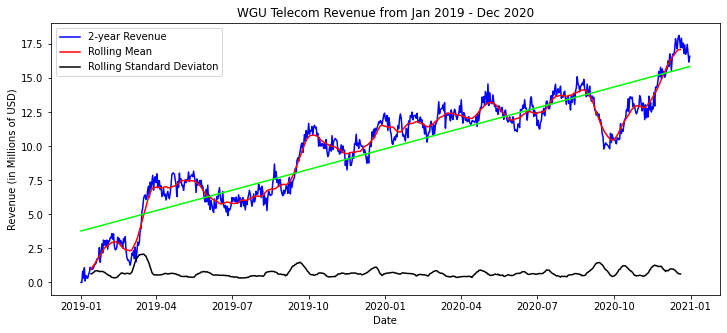

In [ ]:
# Explore the data by Visualizing the data.
plt.figure(figsize=(12,5))
org = plt.plot(df['Revenue'], color = 'blue', label = '2-year Revenue')
r_mean = plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
r_std = plt.plot(rolling_stdv, color = 'black', label = 'Rolling Standard Deviaton')
plt.legend(loc = 'best')
plt.title("WGU Telecom Revenue from Jan 2019 - Dec 2020")
plt.xlabel("Date")
plt.ylabel("Revenue (in Millions of USD)")
# Create a trend line
# Source --- (Zach, 2022)
x = mdates.date2num(df.index)
y = df['Revenue']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
# Plot trendline
plt.plot(x, p(x), color = 'lime')
plt.show()

# Data shows an upward trend

<a name="test-for-stationarity"></a>
# Tests for Stationarity
- Run a Dickey-Fuller test
  - Enforce stationarity if necessary
- Plot to confirm stationarity



In [ ]:
# Compute augmented dickey-fuller to mathematically test for stationarity of dataset
# Default autolag argument measurment is AIC
dickey_fuller_results = adfuller(df['Revenue'])

In [ ]:
# Dickey Fuller Results
# Source --- (Statsmodels, n.d.)
df_test_output = pd.Series(dickey_fuller_results[0:4], index = ['Test Statistic', 'p-value', 'Number of Lags', 'Number of Observations'])

for key, value in dickey_fuller_results[4].items():
        df_test_output["Critical Value (%s)" % key] = value

# View Dickey-Fuller results
print(df_test_output)

Test Statistic             -1.924612
p-value                     0.320573
Number of Lags              1.000000
Number of Observations    729.000000
Critical Value (1%)        -3.439352
Critical Value (5%)        -2.865513
Critical Value (10%)       -2.568886
dtype: float64


In [ ]:
# P-value above alpha of 0.05, must reject null hypothesis and proceed to make data stationary
# Detrend data using diff() function to apply differencing
df_difference = df.diff()

# Differencing will result with null value for first value as no previous value to difference, proceed to drop nulls
df_difference = df_difference.dropna()

In [ ]:
# Compute augmented dickey-fuller test for stationarity of dataset
diff_results = adfuller(df_difference['Revenue'])

# Get results of differencing
diff_test_output = pd.Series(diff_results[0:4], index = ['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations'])

for key, value in diff_results[4].items():
        diff_test_output["Critical Value (%s)" % key] = value

# View Dickey-Fuller results
print(diff_test_output)

# Very good test statistic, and critical values well below test stat are signs of stationary data

Test Statistic            -44.874527
p-value                     0.000000
Number of Lags Used         0.000000
Number of Observations    729.000000
Critical Value (1%)        -3.439352
Critical Value (5%)        -2.865513
Critical Value (10%)       -2.568886
dtype: float64


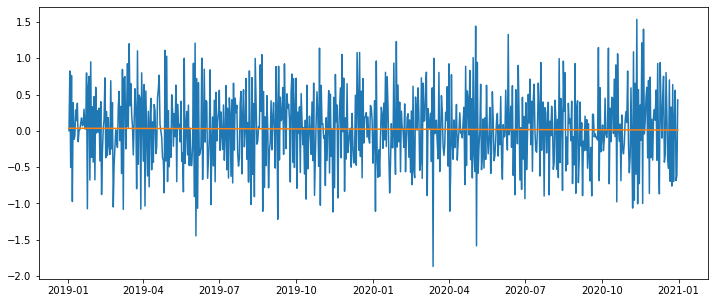

In [ ]:
# Plot of Stationary data
plt.figure(figsize=(12,5))
plt.plot(df_difference)
x = mdates.date2num(df_difference.index)
y = df_difference['Revenue']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
# Plot trendline
plt.plot(x, p(x))
plt.show()

plt.show()

<a name="seasonality-and-decomposition"></a>
# Seasonality and Decomposition
- Seasonal decomposition plot
- Decomposition trend plot


<Figure size 1440x864 with 0 Axes>

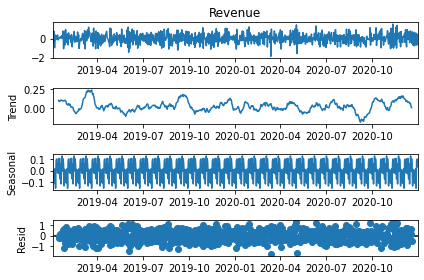

In [ ]:
# Decompose churn data to check for seasonality
decomp = seasonal_decompose(df_difference['Revenue'], period = 24)

# Plot decomposed data
plt.figure(figsize = (20, 12))
decomp.plot();

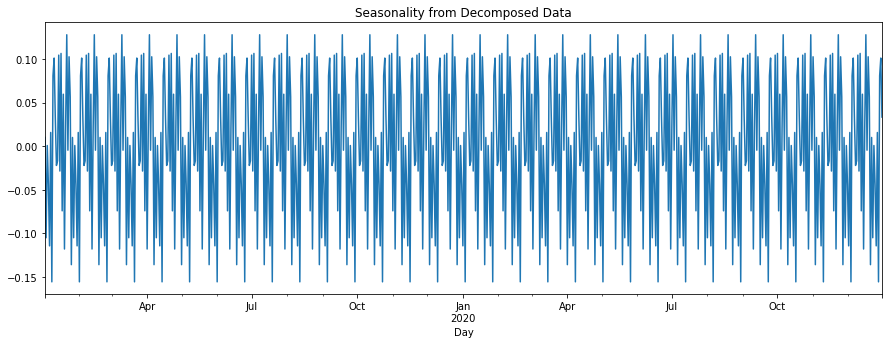

In [ ]:
# Plot of decomposition for seasonality
plt.figure(figsize = (15, 5))
decomp.seasonal.plot()
plt.title("Seasonality from Decomposed Data")
plt.show()

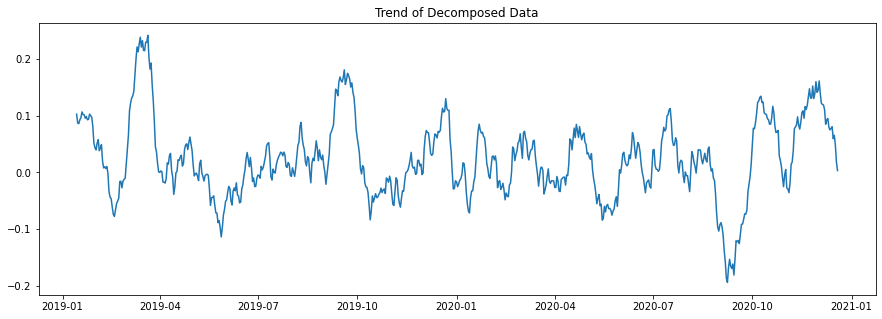

In [ ]:
# Plot Trend of decomposed data for PA
plt.figure(figsize = (15, 5))
plt.plot(decomp.trend)
plt.title("Trend of Decomposed Data")
plt.show()

<a name="model-selection"></a>
# Model Selection and Preperation
- Determine values of p,d,q for ARIMA model
- Run ACF to define value of q
- Run PACF to define value of p
- Plot for spectral density
- Plot of decomposed residuals
- 80/20 Train-Test split

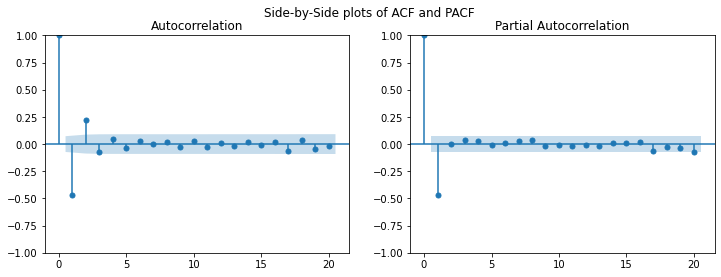

In [ ]:
# Determine values for ARIMA model order (p, d, q)
# Prepare plot for side by side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
fig.suptitle('Side-by-Side plots of ACF and PACF')
# Run ACF for value of "q"
plot_acf(df_difference['Revenue'], lags = 20, alpha = 0.05, ax = ax1)
# Run PACF for value of "p"
plot_pacf(df_difference['Revenue'], lags = 20, alpha = 0.05, ax = ax2)
plt.show()

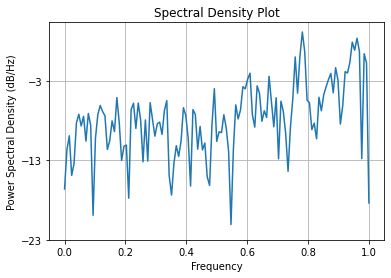

In [ ]:
# Plot spectral density of dataset
plt.psd(df_difference['Revenue'])
plt.title("Spectral Density Plot")
plt.show()

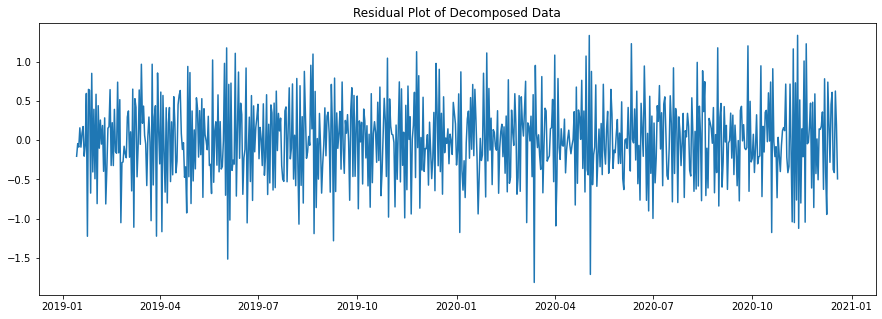

In [ ]:
# Plot of decomposed residuals
plt.figure(figsize = (15, 5))
plt.plot(decomp.resid)
plt.title("Residual Plot of Decomposed Data")
plt.show()

In [ ]:
# Run auto_arima --- confirm best model is AR(1)
# Confirm no seasonality in dataset
# SOURCE --- (Sewell, n.d.)
# Fit data with auto_arima model and view summary to obtain optimal p,d,q values and look for seasonality
stepwise_fit = auto_arima(df_difference['Revenue'], trace = True, suppress_warnings = True)
stepwise_fit.summary()

# Best model values for p,d,q confirmed --- (1, 0, 0) --- no seasonality detected given results

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=987.305, Time=2.99 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1162.819, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=983.122, Time=0.32 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1019.369, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1162.139, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=985.104, Time=0.65 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=985.106, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=986.045, Time=2.24 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=984.710, Time=0.07 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 7.503 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -488.561
Date:                Tue, 26 Sep 2023   AIC                            983.122
Time:                        17:28:40   BIC                            996.901
Sample:                    01-02-2019   HQIC                           988.438
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0332      0.018      1.895      0.058      -0.001       0.068
ar.L1         -0.4692      0.033    -14.296      0.000      -0.534      -0.405
sigma2         0.2232      0.013     17.801      0.000       0.199       0.248
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.05
Prob(Q):                              0.96   Prob(JB):                         0.36
Heteroskedasticity (H):               1.02   Skew:                            -0.02
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Prepare data for test and train sets using an 80/20 split
# Data will be split in sequential order for model

train_size = round(len(df)*0.8)
test_size = round(len(df)*0.2)

print("Train set size: " + str(train_size))
print("Test set size: " + str(test_size))

Train set size: 585
Test set size: 146


In [ ]:
# Split stationary detrended data into train and test sets
# First 80% of data for train, and last 20% for test sets
train = df_difference.iloc[:-146]
test = df_difference.iloc[-146:]

# Confirm accurate split for train/test sets
print("Train Set Shape: " + str(train.shape))
print("Test Set Shape: " + str(test.shape))

Train Set Shape: (584, 1)
Test Set Shape: (146, 1)


<a name="run-model"></a>
# Run Model
- Fit train data to defined ARIMA model


In [ ]:
# Run training model and fit dataset
model = ARIMA(train['Revenue'], order = (1, 0, 0), freq = 'D')
results = model.fit()

# View result summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -383.946
Date:                Tue, 26 Sep 2023   AIC                            773.893
Time:                        17:31:38   BIC                            787.002
Sample:                    01-02-2019   HQIC                           779.002
                         - 08-07-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0234      0.013      1.758      0.079      -0.003       0.049
ar.L1         -0.4597      0.036    -12.654      0.000      -0.531      -0.388
sigma2         0.2180      0.014     16.034      0.0

<a name="results"></a>
# Results
- Plot of forecasted mean
- Plot revenue forecast for next two quarters
- Calculate RMSE of forecast model

2020-08-08   -0.048621
2020-08-09    0.056441
2020-08-10    0.008147
2020-08-11    0.030347
2020-08-12    0.020142
                ...   
2020-12-27    0.023356
2020-12-28    0.023356
2020-12-29    0.023356
2020-12-30    0.023356
2020-12-31    0.023356
Freq: D, Name: predicted_mean, Length: 146, dtype: float64


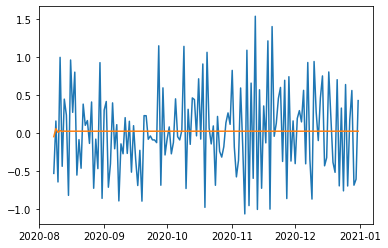

In [ ]:
# Get forecasted results from model - test data is last 146 values, set start to 584 and end to 729
forecasted = results.get_prediction(start = 584, end = 729, dynamic = True)

# Plot Test data compared to forecasted predicted mean
plt.plot(test)
plt.plot(forecasted.predicted_mean);

# View predicted mean values
print(forecasted.predicted_mean)

In [ ]:
# Create forecasted plot of train and test results
# Create temporary df for forcasted means
forecast_temp = pd.DataFrame(forecasted.predicted_mean)

# Rename predicted mean column to match Revenue column name
forecast_temp.rename(columns = {'predicted_mean' : 'Revenue'}, inplace = True)

# Aggregate Train data and forecasted values into one df
df_forecast = pd.concat([train.copy(), forecast_temp.copy()])

# df values are the average differences in daily revenue - apply cumulative summation for forecast
df_forecast = df_forecast.cumsum()

# Check output to verify expected values
df_forecast

,Revenue
2019-01-02,0.000793
2019-01-03,0.825542
2019-01-04,0.320332
2019-01-05,1.082554
2019-01-06,0.107654
...,...
2020-12-27,16.952019
2020-12-28,16.975375
2020-12-29,16.998730
2020-12-30,17.022086


In [ ]:
# Calculate confidence intervals from forecasted data
confidence_intervals = forecasted.conf_int()
# Like the forecast, these confidence limits are also differences in daily revenue, these need transformed back to daily revenue
confidence_intervals

,lower Revenue,upper Revenue
2020-08-08,-0.963665,0.866422
2020-08-09,-0.950645,1.063528
2020-08-10,-1.017331,1.033625
2020-08-11,-0.998976,1.059669
2020-08-12,-1.009990,1.050275
...,...,...
2020-12-27,-1.006994,1.053705
2020-12-28,-1.006994,1.053705
2020-12-29,-1.006994,1.053705
2020-12-30,-1.006994,1.053705


In [ ]:
# Find actual revenue value for confidence interval reference for 2020-08-07
print(df[:-146])

# Revenue value to be set to 13.684826

              Revenue
Day                  
2019-01-01   0.000000
2019-01-02   0.000793
2019-01-03   0.825542
2019-01-04   0.320332
2019-01-05   1.082554
...               ...
2020-08-03  14.052184
2020-08-04  13.520478
2020-08-05  13.082643
2020-08-06  13.504886
2020-08-07  13.684826

[585 rows x 1 columns]


In [ ]:
# Establish a new dataframe to match the confidence intervals dataframe, start from 2020-08-07
ci_start = pd.DataFrame({'lower Revenue': [13.684826], 'upper Revenue' : [13.684826], 'date' : ['2020-08-07']})

# Convert date to datetime object and then set as index
ci_start['date'] = pd.to_datetime(ci_start['date'])
ci_start.set_index('date', inplace = True)

# View df
ci_start

,lower Revenue,upper Revenue
date,,
2020-08-07,13.684826,13.684826


In [ ]:
# Combine ci starting point with predicted confidence intervals data
confidence_intervals = pd.concat([ci_start, confidence_intervals])

# Apply cumsum() to aggregate forecasted confidence intervals
confidence_intervals = confidence_intervals.cumsum()

# Apply loc to confidence intervals for forecasted dates only, exclude ci_starting point
confidence_intervals = confidence_intervals.loc['2020-08-08' : '2020-12-31']

# Verify cumulative intervals
confidence_intervals

,lower Revenue,upper Revenue
2020-08-08,26.405987,28.236074
2020-08-09,38.176504,43.850849
2020-08-10,48.929689,60.499250
2020-08-11,58.683899,78.207319
2020-08-12,67.428118,96.965663
...,...,...
2020-12-27,-8253.580063,12627.665073
2020-12-28,-8383.799929,12791.835688
2020-12-29,-8515.026789,12957.060009
2020-12-30,-8647.260642,13123.338035


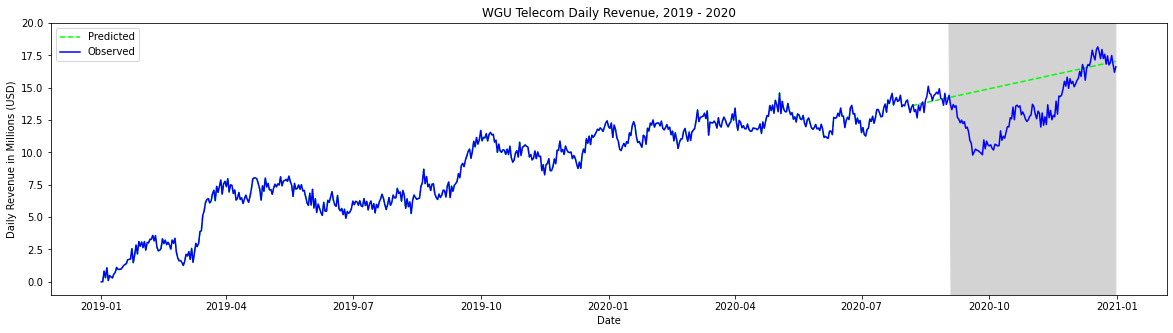

In [ ]:
# Plot Revenue forecast
# Plot the forecasted data, non-differenced/original df, and confidenciee intervals of forecasted data
plt.figure(figsize = [20,5])
plt.plot(df_forecast, color = 'lime', linestyle = '--')
plt.plot(df, color = 'blue')
plt.fill_between(confidence_intervals.index, confidence_intervals['lower Revenue'], confidence_intervals['upper Revenue'], color = 'lightgray')

# Plot details
# Scale plot relative to forecasted revenue range, min set to -1 to show start of revenue stream
plt.ylim(-1, 20)
plt.title("WGU Telecom Daily Revenue, 2019 - 2020")
plt.xlabel("Date")
plt.ylabel("Daily Revenue in Millions (USD)")
plt.legend(['Predicted', 'Observed'])
plt.show()

In [ ]:
# Test set - no differencing
test_full = df.iloc[-146:]


In [ ]:
# Get predictions for RMSE calculation
predict = results.forecast(len(test))


In [ ]:
#Calculate RMSE of differenced model

rmse = sqrt(mean_squared_error(predict, test['Revenue']))
print(f"The RMSE of the differenced model: {round(rmse,3)}")

# Confirmed an accurate model

The RMSE of the differenced model: 0.57


In [ ]:
# Calculate root mean squared error of forecasted data against the observed data with no differencing
rmse_revenue = sqrt(mean_squared_error(df['Revenue'].loc['2020-08-08' : '2020-12-31'], df_forecast['Revenue'].loc['2020-08-08' : '2020-12-31']))
print(f"The RMSE of the forecasted model: {round(rmse_revenue, 3)}")

The RMSE of the forecasted model: 2.474


In [ ]:
###########################################################################################

In [ ]:
###########################################################################################

In [ ]:
###########################################################################################